In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#-------Import Dependencies-------#
import pandas as pd
import os,shutil,math
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.applications import VGG16
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [ ]:
input_dir='../Downloads/562468_1022626_compressed_Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/'
SAMPLE_COUNT = 1000
TESTING_BATCH_SIZE = 500
labels=pd.read_csv( input_dir +'datasets_562468_1022626_Chest_xray_Corona_Metadata.csv')

In [ ]:
training_dir = input_dir + 'train/'
df = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.jpeg'))})
df['id']=labels['X_ray_image_name']
df['label']=labels['Label']

In [ ]:
x= df[df.label=='Normal']
y= df[df.label=='Pnemonia']
df = pd.concat([x,y]).reset_index()

In [ ]:
train_path = '/content/drive/My Drive/covid'
val_path = '/content/drive/My Drive/19'

for directory in [train_path,val_path]:
    for sub_directory in ['Normal','Pnemonia']:
        path = os.path.join(directory,sub_directory)
        os.makedirs(path,exist_ok=True)
        
train,val = train_test_split(df,train_size=0.8,stratify=df['label'])
df.set_index('id',inplace=True)

for images_paths in [(train,train_path),(val,val_path)]:
    images = images_paths[0]
    path = images_paths[1]
    for image in images['id'].values:
        file_name = image + ''
        label = str(df.loc[image,'label'])
        destination = os.path.join(path,label,file_name)
        if not os.path.exists(destination):
            source = os.path.join(input_dir + 'train',file_name)
            img=Image.open(source)
            new_image=img.resize((224,224))
            new_image.save(file_name)
            shutil.move(file_name,destination)

In [ ]:
#------Generators------------#
train_augs = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    channel_shift_range=0.1
)


val_augs = ImageDataGenerator(rescale=1./255)

train_gen = train_augs.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=10,
    class_mode='binary')

val_gen = val_augs.flow_from_directory(
    val_path,
    target_size=(224,224),
    batch_size=10,
    class_mode='binary')
print(train_gen.class_indices)

Found 4211 images belonging to 2 classes.
Found 1053 images belonging to 2 classes.
{'Normal': 0, 'Pnemonia': 1}


In [ ]:
base_model = VGG19(include_top=False,
                  input_shape = (224,224,3),
                  weights = 'imagenet')

for layer in base_model.layers[:-15]:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

80142336/80134624 [==============================] - 3s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7fa3a2495160> False
<keras.layers.convolutional.Conv2D object at 0x7fa3a2495630> False
<keras.layers.convolutional.Conv2D object at 0x7fa3a2495828> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa3a2495c18> False
<keras.layers.convolutional.Conv2D object at 0x7fa3a2495ba8> False
<keras.layers.convolutional.Conv2D object at 0x7fa3a2441be0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa3a244c780> False
<keras.layers.convolutional.Conv2D object at 0x7fa3a244c5c0> True
<keras.layers.convolutional.Conv2D object at 0x7fa3a24502e8> True
<keras.layers.convolutional.Conv2D object at 0x7fa3a2450e48> True
<keras.layers.convolutional.Conv2D object at 0x7fa3a24598d0> True
<keras.layers.pooling.MaxPooling2D object at 0x7fa3a245e358> True
<keras.layers.convolutional.Conv2D object at 0x7fa3a245e198> True
<keras.layers.convolutional.Conv2D object at 0x7fa3a245ee80> True
<k

In [ ]:
#-------Callbacks-------------#
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '
/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


In [ ]:
# Training the model
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=2e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 500, 
    validation_data  = val_gen,
    validation_steps = 500,
    epochs = 30, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/30
500/500 [==============================] - 3473s 7s/step - loss: 0.3378 - accuracy: 0.8503 - val_loss: 0.1036 - val_accuracy: 0.9067

Epoch 00001: val_loss improved from inf to 0.10359, saving model to ./base.model
Epoch 2/30
500/500 [==============================] - 310s 619ms/step - loss: 0.2344 - accuracy: 0.9048 - val_loss: 0.2763 - val_accuracy: 0.9074

Epoch 00002: val_loss did not improve from 0.10359
Epoch 3/30
500/500 [==============================] - 309s 619ms/step - loss: 0.1724 - accuracy: 0.9349 - val_loss: 0.0986 - val_accuracy: 0.9210

Epoch 00003: val_loss improved from 0.10359 to 0.09855, saving model to ./base.model
Epoch 4/30
500/500 [==============================] - 309s 618ms/step - loss: 0.1917 - accuracy: 0.9261 - val_loss: 0.0209 - val_accuracy: 0.9316

Epoch 00004: val_loss improved from 0.09855 to 0.02086, saving model to ./base.model
Epoch 5/30
500/500 [==============================] - 309s 619ms/step - loss: 0.1673 - accuracy: 0.9375 - val_lo

In [ ]:
#----Custom function to visualize the training of the model------#
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

Validation Accuracy: [0.9365558624267578]


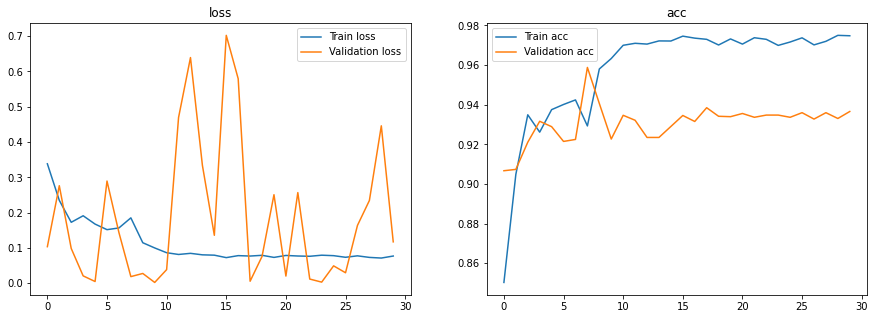

In [ ]:
show_final_history(history)
print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

Found 1053 images belonging to 2 classes.
106/106 [==============================] - 21s 202ms/step


NameError: ignored

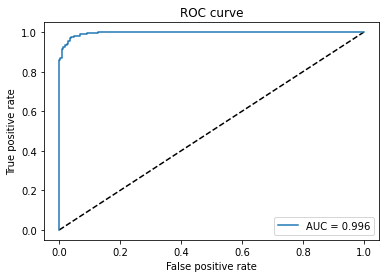

In [ ]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                                  target_size=(224,224),
                                                                                  batch_size=10,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)
predictions = model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=1)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()